In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import csv
import ast

In [2]:
models = ["fastdepth", "pydnet"]
orangePostRadius = 0.15
metalPanelWH = (1, 0.06)
whitepanelWH = (1.45, 0.06)

dronePos = (0, -4)
stageSize = (10, 10)

In [3]:
def calcDist(coords1, coords2):
    return np.sqrt((coords2[0]-coords1[0])**2 + (coords2[1]-coords1[1])**2)
def getObstaclePos(dronePos, goalPos, obstDist):
    distGoalDrone = calcDist(dronePos, goalPos)
    return (dronePos[0] + obstDist/distGoalDrone * (goalPos[0]-dronePos[0]), dronePos[1] + obstDist/distGoalDrone * (goalPos[1]-dronePos[1]))

class Run:
    colorDict = {5: "red", 7: "yellow", 9: "lime", 11: "aqua", 13: "blue", 15: "purple"}
    def __init__(self, N, completed, distance, time, coords, goalPos, model):
        self.N = N
        self.completed = completed
        self.distance = distance
        self.time = time
        self.coords = coords
        self.goalPos = goalPos
        self.x = [coord[0] for coord in coords]
        self.y = [coord[1] for coord in coords]
        self.model = model
        self.color = self.colorDict[N]
        
class TrajectoryPlot:
    def __init__(self, levelIdx, runIdx, fullresults, dronePos, goalPos, stageSize, model):
        self.levelIdx = levelIdx
        self.runIdx = runIdx
        self.fullresults = fullresults
        self.dronePos = dronePos
        self.goalPos = goalPos
        self.stageSize = [[stageSize[0]/2-stageSize[0], stageSize[0]/2], [stageSize[1]/2-stageSize[1], stageSize[1]/2]]
        self.model = model
        self.fig, self.ax = plt.subplots(figsize=(8,8))
        self.runs = self.getRuns(runIdx)
        self.obstacles = self.getObstacles(runIdx)
    def getRuns(self, runIdx):
        runs = []
        for _, run in self.fullresults[self.fullresults["run"] == runIdx].iterrows():
            runs.append(Run(run["N"], bool(run["Completed"]), run["Distance"], run["Time"], ast.literal_eval(run["Coords"]), (run["goalX"], run["goalY"]),  self.model))
        return runs
    def getObstacles(self, runIdx):
        obstacles = []
        runinfo = self.fullresults[self.fullresults["run"] == runIdx]
        goalPos = (runinfo.iloc[0]["goalX"], runinfo.iloc[0]["goalY"])
        if self.levelIdx >= 1:
            obst1Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst1Dist'])
            obstacles.append(plt.Circle(obst1Pos, orangePostRadius, color="orange"))
        if self.levelIdx >= 2:
            obst2Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst2Dist'])
            obst2Angle = runinfo.iloc[0]['obst2Angle']
            rect = plt.Rectangle(obst2Pos, metalPanelWH[0], metalPanelWH[1], color="grey")
            rect.set_x(rect.get_x() - metalPanelWH[0]/2)
            rect.set_y(rect.get_y() - metalPanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst2Pos[0], obst2Pos[1], np.rad2deg(obst2Angle)) + self.ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        if self.levelIdx >= 3:
            obst3Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst3Dist'])
            obst3Angle = runinfo.iloc[0]['obst3Angle']
            rect = plt.Rectangle(obst3Pos, whitepanelWH[0], whitepanelWH[1], color="black")
            rect.set_x(rect.get_x() - whitepanelWH[0]/2)
            rect.set_y(rect.get_y() - whitepanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst3Pos[0], obst3Pos[1], np.rad2deg(obst3Angle)) + self.ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        return obstacles
    def addRun(self, N, completed, distance, time, coords, model):
        self.runs.append(Run(N, completed, distance, time, coords, model))
    def addCircle(self, pos, radius, color):
        self.obstacles.append(plt.Circle(pos, radius, color=color))
    def addRectangle(self, pos, width, height, angle, color):
        rect = plt.Rectangle(pos, width, height, color=color)
        rect.set_x(rect.get_x() - width/2)
        rect.set_y(rect.get_y() - height/2)
        tr = mpl.transforms.Affine2D().rotate_deg_around(pos[0], pos[1], np.rad2deg(angle)) + self.ax.transData
        rect.set(transform=tr)
        self.obstacles.append(rect)
    def plot(self):
        for run in self.runs:
            self.ax.plot(run.x, run.y, label=f"{run.N} - {run.completed}", color=run.color, alpha=0.5)
            if run.completed:
                self.ax.plot(run.coords[-1][0], run.coords[-1][1], marker="D", markersize=6, markerfacecolor="green", markeredgecolor="black")
            else:
                self.ax.plot(run.coords[-1][0], run.coords[-1][1], marker="X", markersize=6, markerfacecolor="red", markeredgecolor="black")
        for obstacle in self.obstacles:
            self.ax.add_patch(obstacle)
        self.ax.plot(self.dronePos[0], self.dronePos[1], marker="P", markersize=12, markerfacecolor="grey", markeredgecolor="black")
        self.ax.plot(self.goalPos[0], self.goalPos[1], marker="D", markersize=12, markerfacecolor="gold", markeredgecolor="black")
        self.ax.legend()
        self.ax.set_title(f"Level {self.levelIdx} - Setup {self.runIdx} - Model: {self.model}")
        plt.xlim(self.stageSize[0])
        plt.ylim(self.stageSize[1])
        plt.tick_params(axis='both', labelsize=0, length = 0)
        plt.savefig(f"level{self.levelIdx}Plot.png", bbox_inches="tight")
#         plt.show()

# class LevelPlot:
#     def __init__(self, levelIdx, fullresults, dronePos, stageSize, model, ncols, nrows):
#         self.levelIdx = levelIdx
#         self.fullresults = fullresults
#         self.nruns = fullresults["run"].nunique()
#         self.dronePos = dronePos
#         self.stageSize = [[stageSize[0]/2-stageSize[0], stageSize[0]/2], [stageSize[1]/2-stageSize[1], stageSize[1]/2]]
#         self.fig, self.axs = plt.subplots(nrows, ncols, figsize=(50, 110))
#         self.model = model
#         self.plotpos = [(i, j) for i in range(nrows) for j in range(ncols)]
#     def getRuns(self, runIdx):
#         runs = []
#         for _, run in self.fullresults[self.fullresults["run"] == runIdx].iterrows():
#             runs.append(Run(run["N"], bool(run["Completed"]), run["Distance"], run["Time"], ast.literal_eval(run["Coords"]), (run["goalX"], run["goalY"]),  self.model))
#         return runs
#     def getObstacles(self, runIdx):
#         obstacles = []
#         runinfo = self.fullresults[self.fullresults["run"] == runIdx]
#         goalPos = (runinfo.iloc[0]["goalX"], runinfo.iloc[0]["goalY"])
#         if self.levelIdx >= 1:
#             obst1Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst1Dist'])
#             obstacles.append(plt.Circle(obst1Pos, orangePostRadius, color="orange"))
#         if self.levelIdx >= 2:
#             obst2Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst2Dist'])
#             obst2Angle = runinfo.iloc[0]['obst2Angle']
#             rect = plt.Rectangle(obst2Pos, metalPanelWH[0], metalPanelWH[1], color="grey")
#             rect.set_x(rect.get_x() - metalPanelWH[0]/2)
#             rect.set_y(rect.get_y() - metalPanelWH[1]/2)
#             tr = mpl.transforms.Affine2D().rotate_deg_around(pos[0], pos[1], np.rad2deg(obst2Angle)) + self.axs.transData
#             rect.set(transform=tr)
#             obstacles.append(rect)
#         if self.levelIdx >= 3:
#             obst3Pos = getObstaclePos(self.dronePos, goalPos, runinfo.iloc[0]['obst3Dist'])
#             obst3Angle = runinfo.iloc[0]['obst3Angle']
#             rect = plt.Rectangle(obst3Pos, whitepanelWH[0], whitepanelWH[1], color="black")
#             rect.set_x(rect.get_x() - whitepanelWH[0]/2)
#             rect.set_y(rect.get_y() - whitepanelWH[1]/2)
#             tr = mpl.transforms.Affine2D().rotate_deg_around(pos[0], pos[1], np.rad2deg(obst3Angle)) + self.axs.transData
#             rect.set(transform=tr)
#             obstacles.append(rect)
#         return obstacles
#     def plot(self):
#         for i in range(self.nruns):
#             runs = self.getRuns(i)
#             obstacles = self.getObstacles(i)
#             rowpos, colpos = self.plotpos[i]
#             for run in runs:
#                 self.axs[rowpos, colpos].plot(run.x, run.y, label=f"{run.N} - {run.completed}", color=run.color, alpha=0.5)
#                 if run.completed:
#                     self.axs[rowpos, colpos].plot(run.coords[-1][0], run.coords[-1][1], marker="D", markersize=6, markerfacecolor="green", markeredgecolor="black")
#                 else:
#                     self.axs[rowpos, colpos].plot(run.coords[-1][0], run.coords[-1][1], marker="X", markersize=6, markerfacecolor="red", markeredgecolor="black")
#             for obstacle in obstacles:
#                 self.axs[rowpos, colpos].add_patch(obstacle)
#             self.axs[rowpos, colpos].plot(self.dronePos[0], self.dronePos[1], marker="P", markersize=12, markerfacecolor="grey", markeredgecolor="black")
#             self.axs[rowpos, colpos].plot(runs[0].goalPos[0], runs[0].goalPos[1], marker="D", markersize=12, markerfacecolor="gold", markeredgecolor="black")
#             self.axs[rowpos, colpos].set_title(f"Setup {i}")
#             self.axs[rowpos, colpos].set_xlim(self.stageSize[0])
#             self.axs[rowpos, colpos].set_ylim(self.stageSize[1])
#             self.axs[rowpos, colpos].legend()
#         plt.tight_layout()
#         plt.show()

class Results:
    def __init__(self, model, levelIdx, dronePos, stageSize):
        self.model = model
        self.levelIdx = levelIdx
        self.results = pd.read_csv(f"results/{model}/level{levelIdx}.csv", header=None, names=["N", "run", "Completed", "Distance", "Time", "Coords"]).infer_objects()
        self.level = pd.read_csv(f"levels/level{levelIdx}.csv").infer_objects()
        self.fullresults = pd.merge(self.results, self.level, on=['run', 'N'], how='inner')
        self.numRuns = self.results["run"].max() + 1
        self.dronePos = dronePos
        self.stageSize = stageSize
    def getGoalPos(self, runIdx):
        run = self.fullresults[self.fullresults["run"]==runIdx]
        return (run["goalX"], run["goalY"])
    def getInfo(self):
        completedRuns = self.results[self.results["Completed"]==1]
        numCompleted = self.results.groupby("N")["Completed"].sum()
        succesRate = numCompleted / self.numRuns
        avgTime = round(completedRuns.groupby("N")["Time"].sum() / numCompleted, 2)
        avgDistance = round(completedRuns.groupby("N")["Distance"].sum() / numCompleted, 2)
        return pd.concat([succesRate.rename("SucRate"), avgTime.rename("avgTime"), avgDistance.rename("avgDist")], axis=1)
    def plotRun(self, runIdx):
        runs = self.fullresults[self.fullresults["run"]==runIdx]
        goalPos = (runs.iloc[0]['goalX'], runs.iloc[0]['goalY'])
        plot = TrajectoryPlot(self.levelIdx, runIdx, self.dronePos, goalPos, self.stageSize, self.model)
        for _, run in runs.iterrows():
            plot.addRun(run["N"], bool(run["Completed"]), run["Distance"], run["Time"], ast.literal_eval(run["Coords"]), self.model)
        if self.levelIdx >= 1:
            obst1Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst1Dist'])
            plot.addCircle(obst1Pos, orangePostRadius, "orange")
        if self.levelIdx >= 2:
            obst2Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst2Dist'])
            obst2Angle = runs.iloc[0]['obst2Angle']
            plot.addRectangle(obst2Pos, metalPanelWH[0], metalPanelWH[1], obst2Angle, "grey")
        if self.levelIdx >= 3:
            obst3pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst3Dist'])
            obst3Angle = runs.iloc[0]['obst3Angle']
            plot.addRectangle(obst3pos, whitepanelWH[0], whitepanelWH[1], obst3Angle, "black")
        plot.plotTrajectory()

In [4]:
class stagePlot:
    def __init__(self, levelIdx, dronePos, stageSize):
        self.levelIdx = levelIdx
        self.resultsFD = pd.read_csv(f"results/fastdepth/level{levelIdx}.csv", header=None, names=["N", "run", "Completed", "Distance", "Time", "Coords"]).infer_objects()
        self.resultsPN = pd.read_csv(f"results/pydnet/level{levelIdx}.csv", header=None, names=["N", "run", "Completed", "Distance", "Time", "Coords"]).infer_objects()
        self.level = pd.read_csv(f"levels/level{levelIdx}.csv").infer_objects()
        self.fullresultsFD = pd.merge(self.resultsFD, self.level, on=['run', 'N'], how='inner')
        self.fullresultsPN = pd.merge(self.resultsPN, self.level, on=['run', 'N'], how='inner')
        self.dronePos = dronePos
        self.stageSize = [[stageSize[0]/2-stageSize[0], stageSize[0]/2], [stageSize[1]/2-stageSize[1], stageSize[1]/2]]
        self.numRuns = self.level["run"].max() + 1
    def getObstacles(self, ax, runIdx):
        obstacles = []
        runs = self.level[self.level["run"] == runIdx]
        goalPos = (runs.iloc[0]["goalX"], runs.iloc[0]["goalY"])
        if self.levelIdx >= 1:
            obst1Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst1Dist'])
            obstacles.append(plt.Circle(obst1Pos, orangePostRadius, color="orange"))
        if self.levelIdx >= 2:
            obst2Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst2Dist'])
            obst2Angle = runs.iloc[0]['obst2Angle']
            rect = plt.Rectangle(obst2Pos, metalPanelWH[0], metalPanelWH[1], color="grey")
            rect.set_x(rect.get_x() - metalPanelWH[0]/2)
            rect.set_y(rect.get_y() - metalPanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst2Pos[0], obst2Pos[1], np.rad2deg(obst2Angle)) + ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        if self.levelIdx >= 3:
            obst3Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst3Dist'])
            obst3Angle = runs.iloc[0]['obst3Angle']
            rect = plt.Rectangle(obst3Pos, whitepanelWH[0], whitepanelWH[1], color="black")
            rect.set_x(rect.get_x() - whitepanelWH[0]/2)
            rect.set_y(rect.get_y() - whitepanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst3Pos[0], obst3Pos[1], np.rad2deg(obst3Angle)) + ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        return obstacles
    def getRuns(self, runIdx, model):
        runs = []
        if model == "fastdepth":
            results = self.fullresultsFD
        elif model == "pydnet":
            results = self.fullresultsPN
        for _, run in results[results["run"] == runIdx].iterrows():
            runs.append(Run(run["N"], bool(run["Completed"]), run["Distance"], run["Time"], ast.literal_eval(run["Coords"]), (run["goalX"], run["goalY"]),  model))
        return runs
    def plot(self):
        fig, axs = plt.subplots(4, 5, figsize=(15, 10))
        for i, ax in enumerate(axs.reshape(-1)):
            if i < 5:
                model = "fastdepth"
            elif i < 10:
                model = "pydnet"
                i -= 5
            elif i < 15:
                model  = "fastdepth"
                i -= 5
            else:
                model = "pydnet"
                i -= 10
            obstacles = self.getObstacles(ax, i)
            runs = self.level[self.level["run"] == i]
            goalPos = (runs.iloc[0]["goalX"], runs.iloc[0]["goalY"])
            for obstacle in obstacles:
                ax.add_patch(obstacle)
            for run in self.getRuns(i, model):
                ax.plot(run.x, run.y, label=f"{run.N}", color=run.color, alpha=0.8)
                if run.completed:
                    ax.plot(run.coords[-1][0], run.coords[-1][1], marker="D", markersize=6, markerfacecolor="green", markeredgecolor="black")
                else:
                    ax.plot(run.coords[-1][0], run.coords[-1][1], marker="X", markersize=6, markerfacecolor="red", markeredgecolor="black")
            ax.plot(self.dronePos[0], self.dronePos[1], marker="P", markersize=12, markerfacecolor="grey", markeredgecolor="black")
            ax.plot(goalPos[0], goalPos[1], marker="D", markersize=12, markerfacecolor="gold", markeredgecolor="black")
            ax.set_xlim(self.stageSize[0])
            ax.set_ylim(self.stageSize[1])
            ax.tick_params(left=False, bottom=False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set(adjustable='box', aspect='equal')
            if i % 5 == 0:
                if model == "fastdepth":
                    ax.set_ylabel(f"FastDepth", fontsize=20)
                elif model == "pydnet":
                    ax.set_ylabel(f"PyD-Net", fontsize=20)
            ax.text(2.6, -4.5, f"Setup {i}", fontsize=14)
        lines_labels = [ax.get_legend_handles_labels()]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=7, fontsize=15)
        plt.subplots_adjust(top = 1, bottom=0, hspace=0.03, wspace=0.03)

        plt.savefig(f"results_stage{self.levelIdx}.png", bbox_inches='tight')
#         plt.show()

In [10]:
class AppendixPlot:
    def __init__(self, levelIdx, dronePos, stageSize):
        self.levelIdx = levelIdx
        self.resultsFD = pd.read_csv(f"results/fastdepth/level{levelIdx}.csv", header=None, names=["N", "run", "Completed", "Distance", "Time", "Coords"]).infer_objects()
        self.resultsPN = pd.read_csv(f"results/pydnet/level{levelIdx}.csv", header=None, names=["N", "run", "Completed", "Distance", "Time", "Coords"]).infer_objects()
        self.level = pd.read_csv(f"levels/level{levelIdx}.csv").infer_objects()
        self.fullresultsFD = pd.merge(self.resultsFD, self.level, on=['run', 'N'], how='inner')
        self.fullresultsPN = pd.merge(self.resultsPN, self.level, on=['run', 'N'], how='inner')
        self.dronePos = dronePos
        self.stageSize = [[stageSize[0]/2-stageSize[0], stageSize[0]/2], [stageSize[1]/2-stageSize[1], stageSize[1]/2]]
        self.numRuns = self.level["run"].max() + 1
    def getObstacles(self, ax, runIdx):
        obstacles = []
        runs = self.level[self.level["run"] == runIdx]
        goalPos = (runs.iloc[0]["goalX"], runs.iloc[0]["goalY"])
        if self.levelIdx >= 1:
            obst1Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst1Dist'])
            obstacles.append(plt.Circle(obst1Pos, orangePostRadius, color="orange"))
        if self.levelIdx >= 2:
            obst2Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst2Dist'])
            obst2Angle = runs.iloc[0]['obst2Angle']
            rect = plt.Rectangle(obst2Pos, metalPanelWH[0], metalPanelWH[1], color="grey")
            rect.set_x(rect.get_x() - metalPanelWH[0]/2)
            rect.set_y(rect.get_y() - metalPanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst2Pos[0], obst2Pos[1], np.rad2deg(obst2Angle)) + ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        if self.levelIdx >= 3:
            obst3Pos = getObstaclePos(self.dronePos, goalPos, runs.iloc[0]['obst3Dist'])
            obst3Angle = runs.iloc[0]['obst3Angle']
            rect = plt.Rectangle(obst3Pos, whitepanelWH[0], whitepanelWH[1], color="black")
            rect.set_x(rect.get_x() - whitepanelWH[0]/2)
            rect.set_y(rect.get_y() - whitepanelWH[1]/2)
            tr = mpl.transforms.Affine2D().rotate_deg_around(obst3Pos[0], obst3Pos[1], np.rad2deg(obst3Angle)) + ax.transData
            rect.set(transform=tr)
            obstacles.append(rect)
        return obstacles
    def getRuns(self, runIdx, model):
        runs = []
        if model == "fastdepth":
            results = self.fullresultsFD
        elif model == "pydnet":
            results = self.fullresultsPN
        for _, run in results[results["run"] == runIdx].iterrows():
            runs.append(Run(run["N"], bool(run["Completed"]), run["Distance"], run["Time"], ast.literal_eval(run["Coords"]), (run["goalX"], run["goalY"]),  model))
        return runs
    def plot(self, startfig):
        if startfig == 9:
            ncols = 1
        else:
            ncols = 3
        fig, axs = plt.subplots(ncols, 2, figsize=(19.5, 23))
        start = startfig
        fdn = start
        pnn = start
        for i, ax in enumerate(axs.reshape(-1)):
            if (i + 1) % 2 == 0:
                model = "pydnet"
                i = pnn
                pnn += 1
            else:
                model = "fastdepth"
                i = fdn
                fdn += 1
            obstacles = self.getObstacles(ax, i)
            runs = self.level[self.level["run"] == i]
            goalPos = (runs.iloc[0]["goalX"], runs.iloc[0]["goalY"])
            for obstacle in obstacles:
                ax.add_patch(obstacle)
            for run in self.getRuns(i, model):
                ax.plot(run.x, run.y, label=f"{run.N} - {run.completed}", color=run.color, alpha=0.6)
                if run.completed:
                    ax.plot(run.coords[-1][0], run.coords[-1][1], marker="D", markersize=6, markerfacecolor="green", markeredgecolor="black")
                else:
                    ax.plot(run.coords[-1][0], run.coords[-1][1], marker="X", markersize=6, markerfacecolor="red", markeredgecolor="black")
            ax.plot(self.dronePos[0], self.dronePos[1], marker="P", markersize=12, markerfacecolor="grey", markeredgecolor="black")
            ax.plot(goalPos[0], goalPos[1], marker="D", markersize=12, markerfacecolor="gold", markeredgecolor="black")
            if i == start:
                ax.set_title("FastDepth" if model == "fastdepth" else "PyD-Net", fontsize=15)
            if model == "fastdepth":
                ax.set_ylabel(f"Stage {self.levelIdx} - Setup {i}", fontsize=15)
            ax.set_xlim(self.stageSize[0])
            ax.set_ylim(self.stageSize[1])
            ax.tick_params(left=False, bottom=False)
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set(adjustable='box', aspect='equal')
            ax.legend(fontsize=10)
        plt.subplots_adjust(top = 1, bottom=0, hspace=0.0, wspace=0.02)
        plt.savefig(f"stage{self.levelIdx}-{start}-{pnn}.png", bbox_inches='tight')
        plt.show()


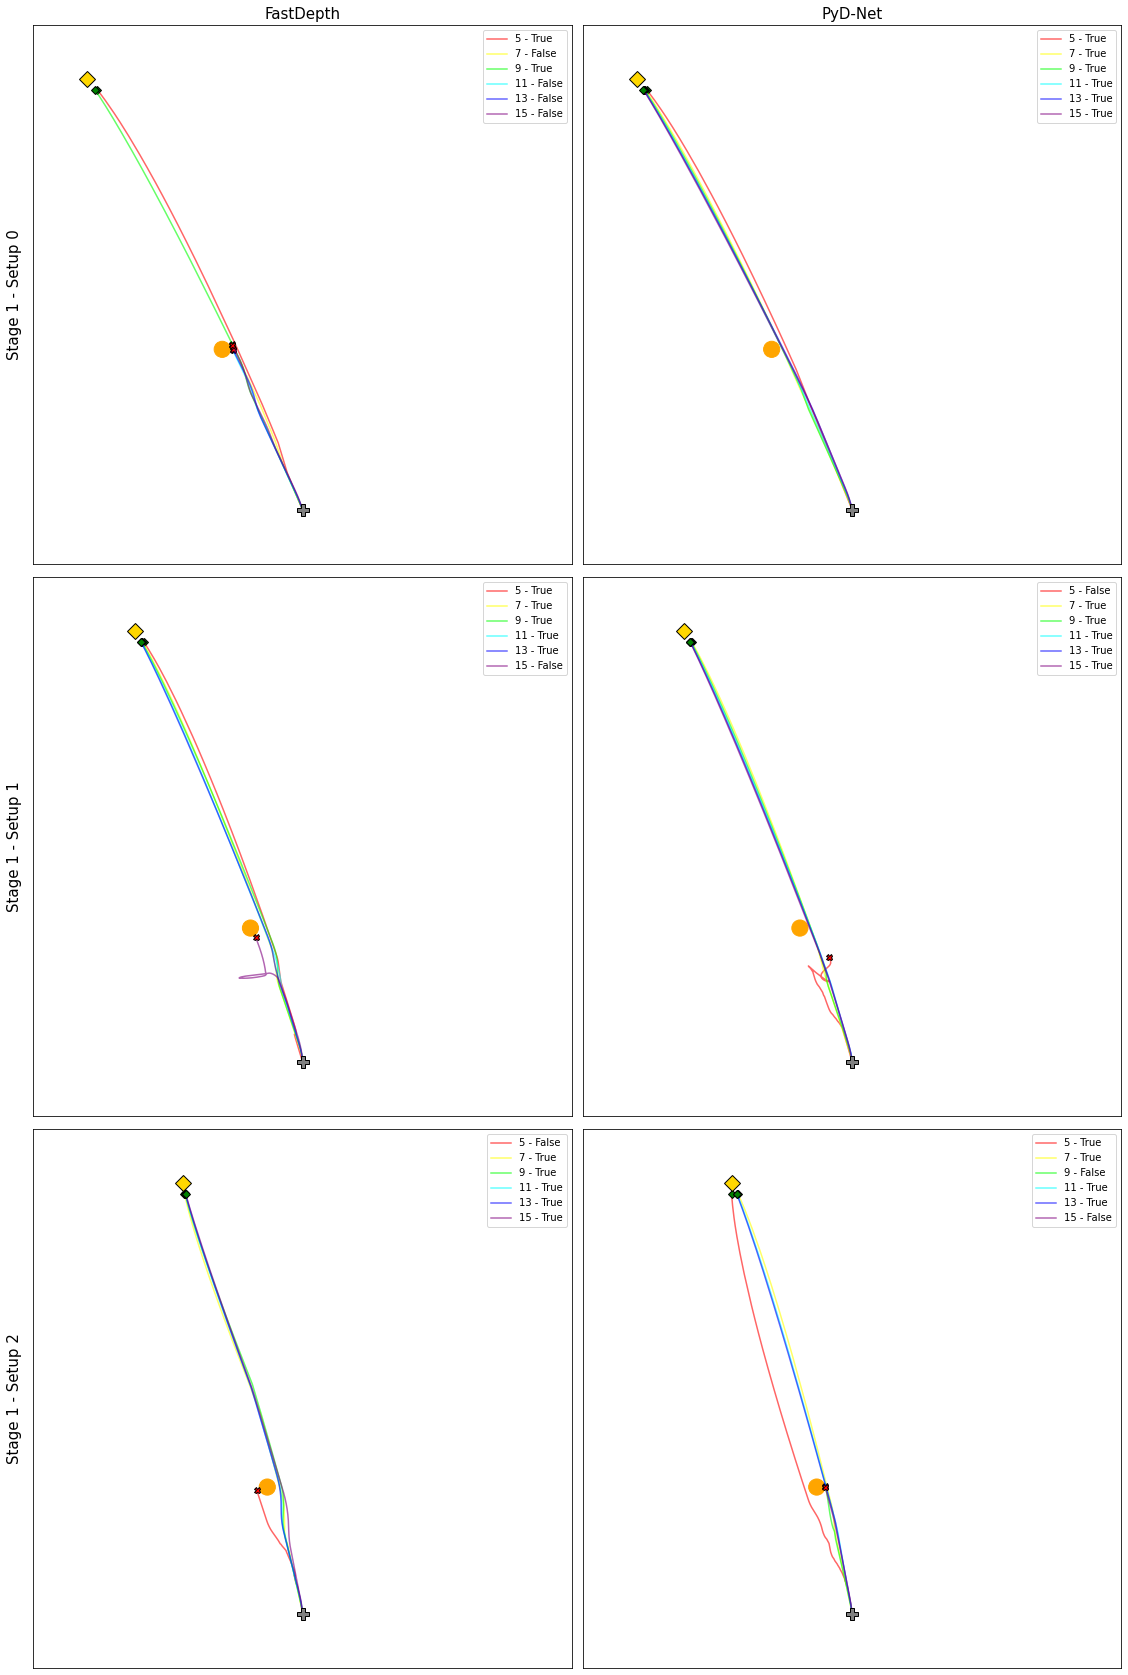

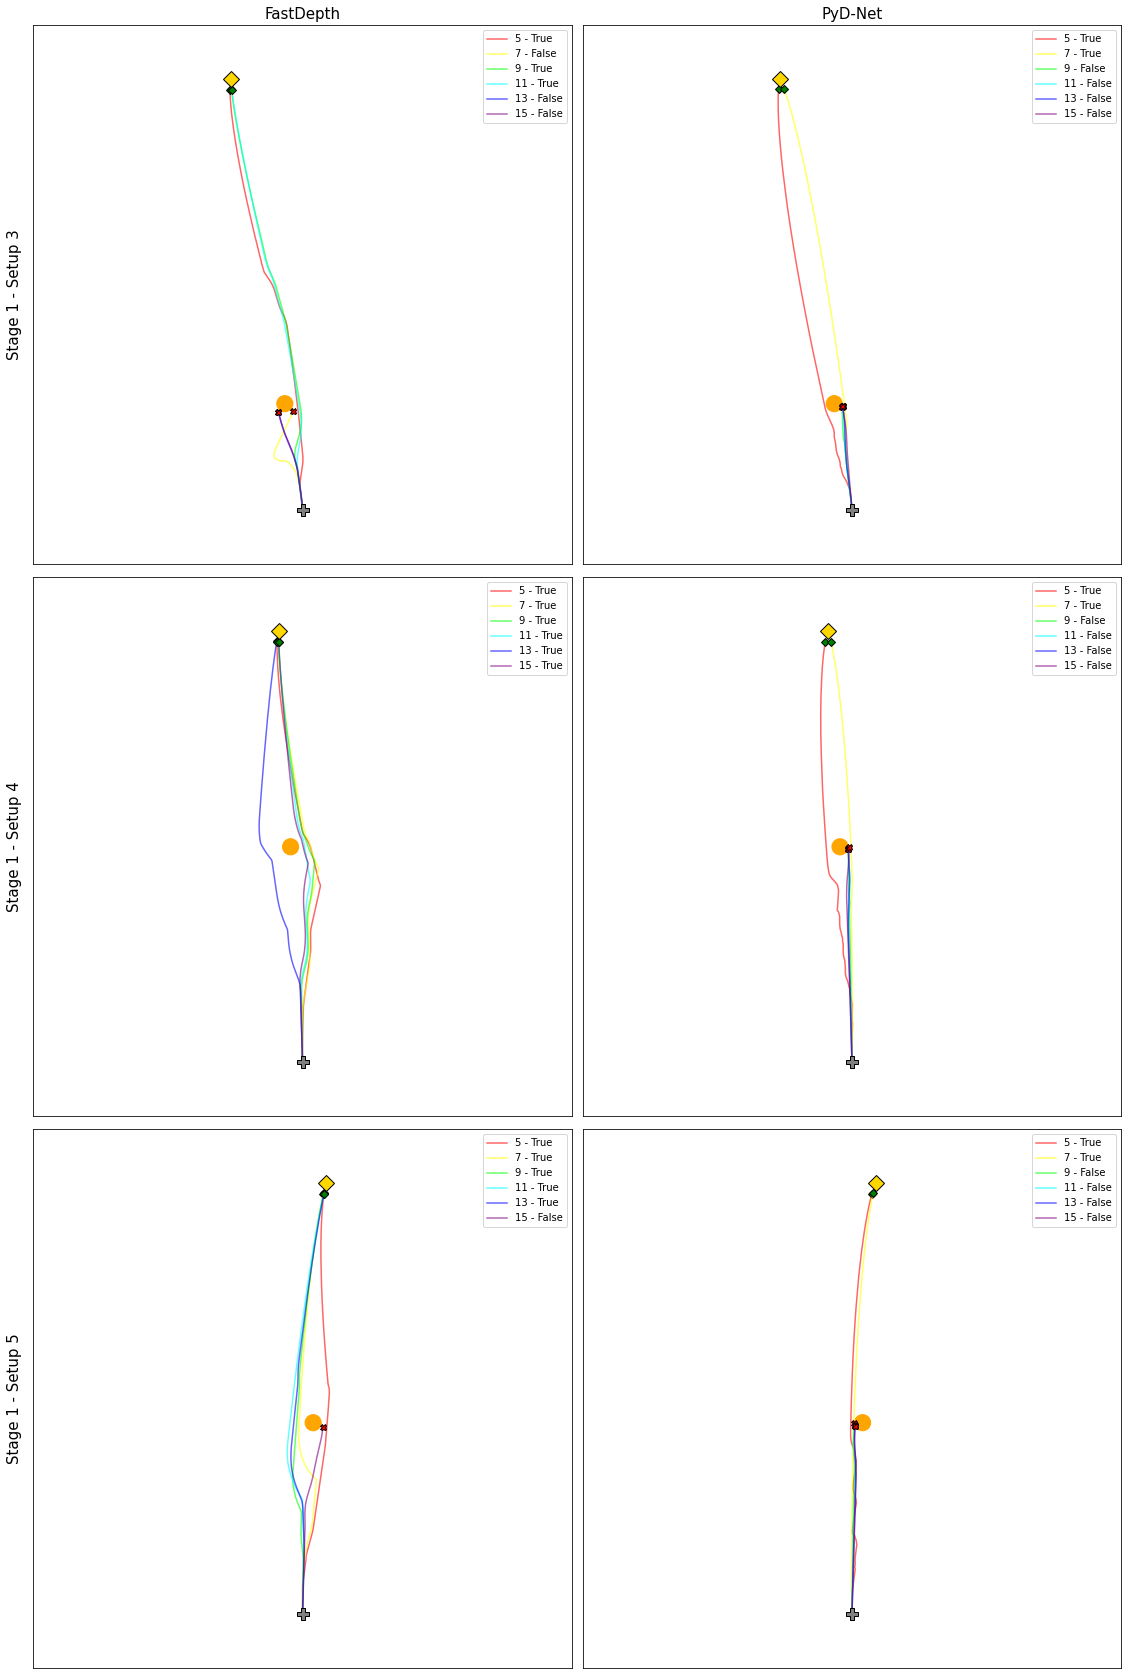

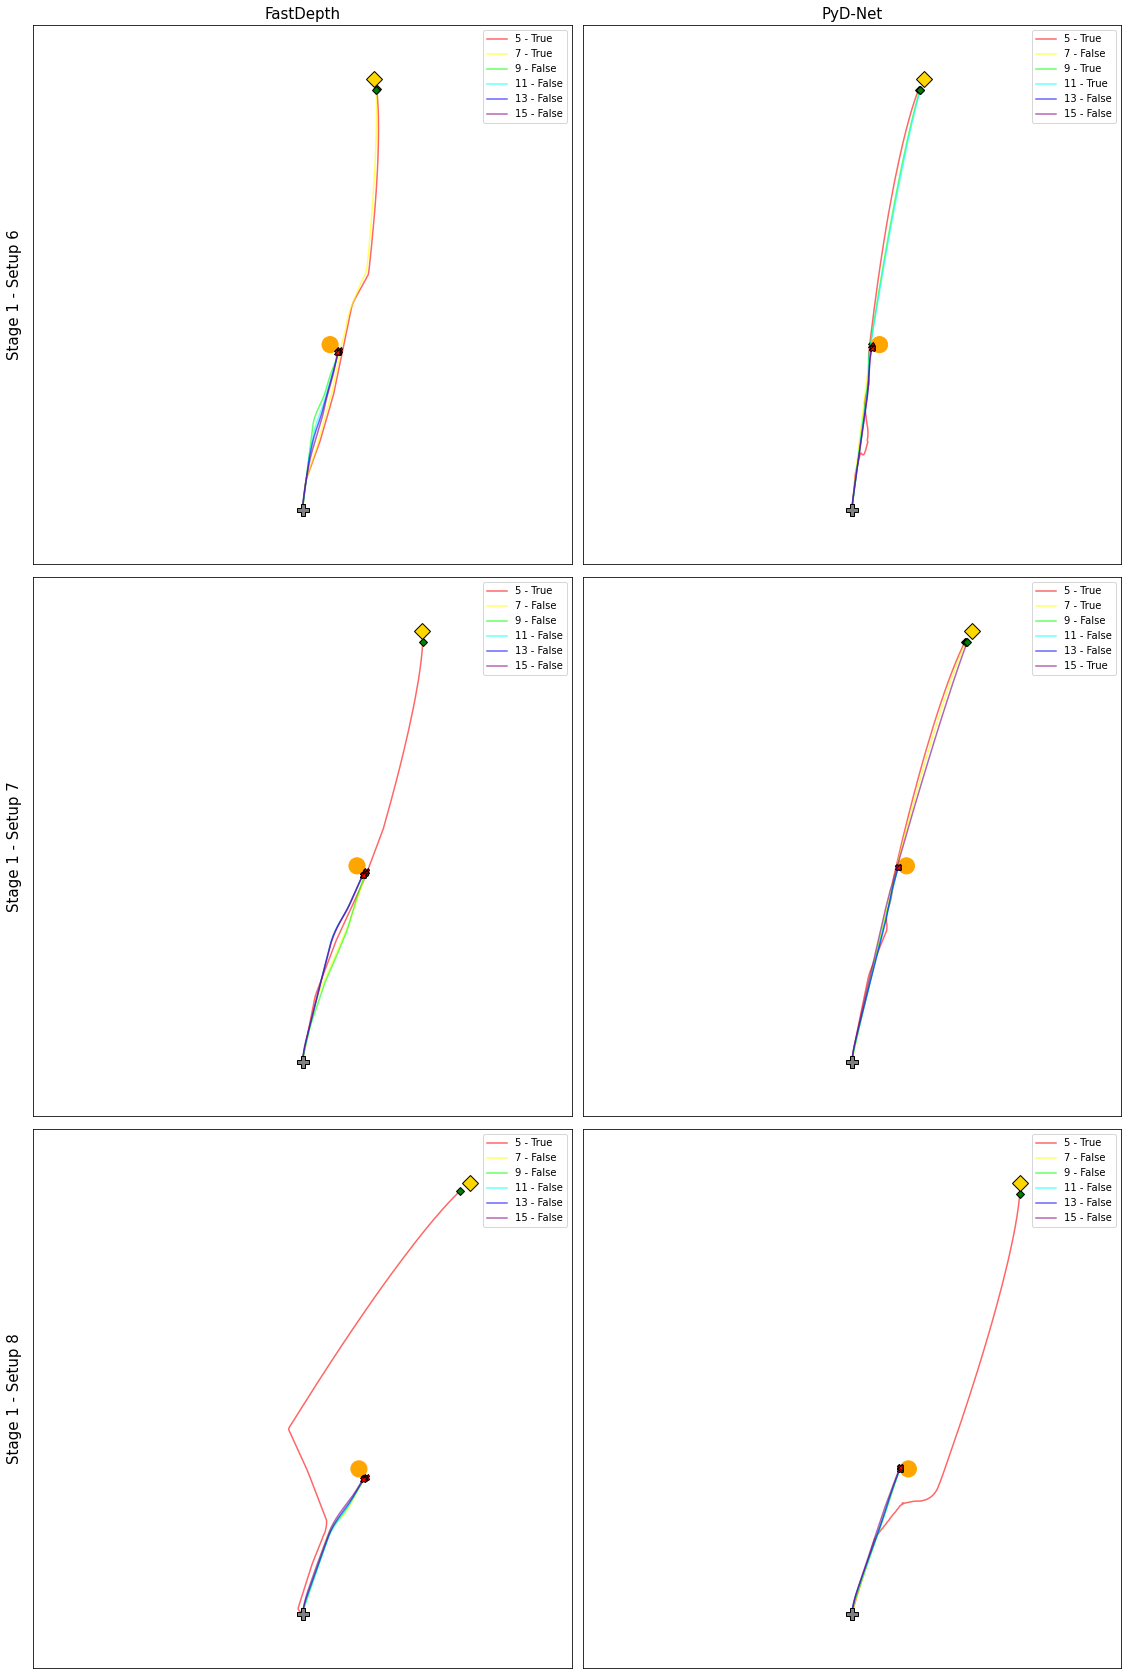

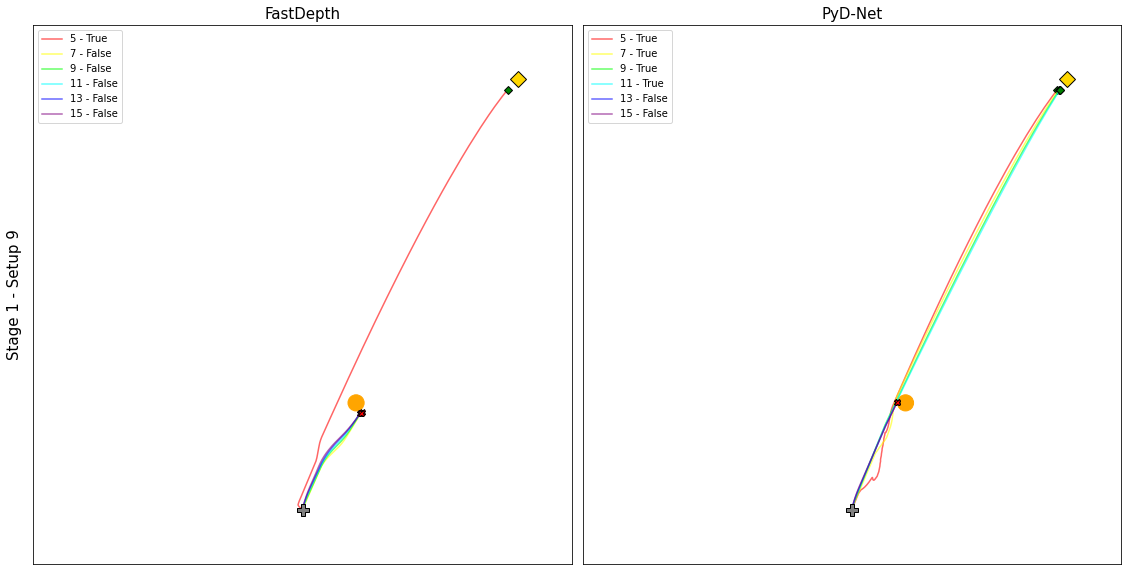

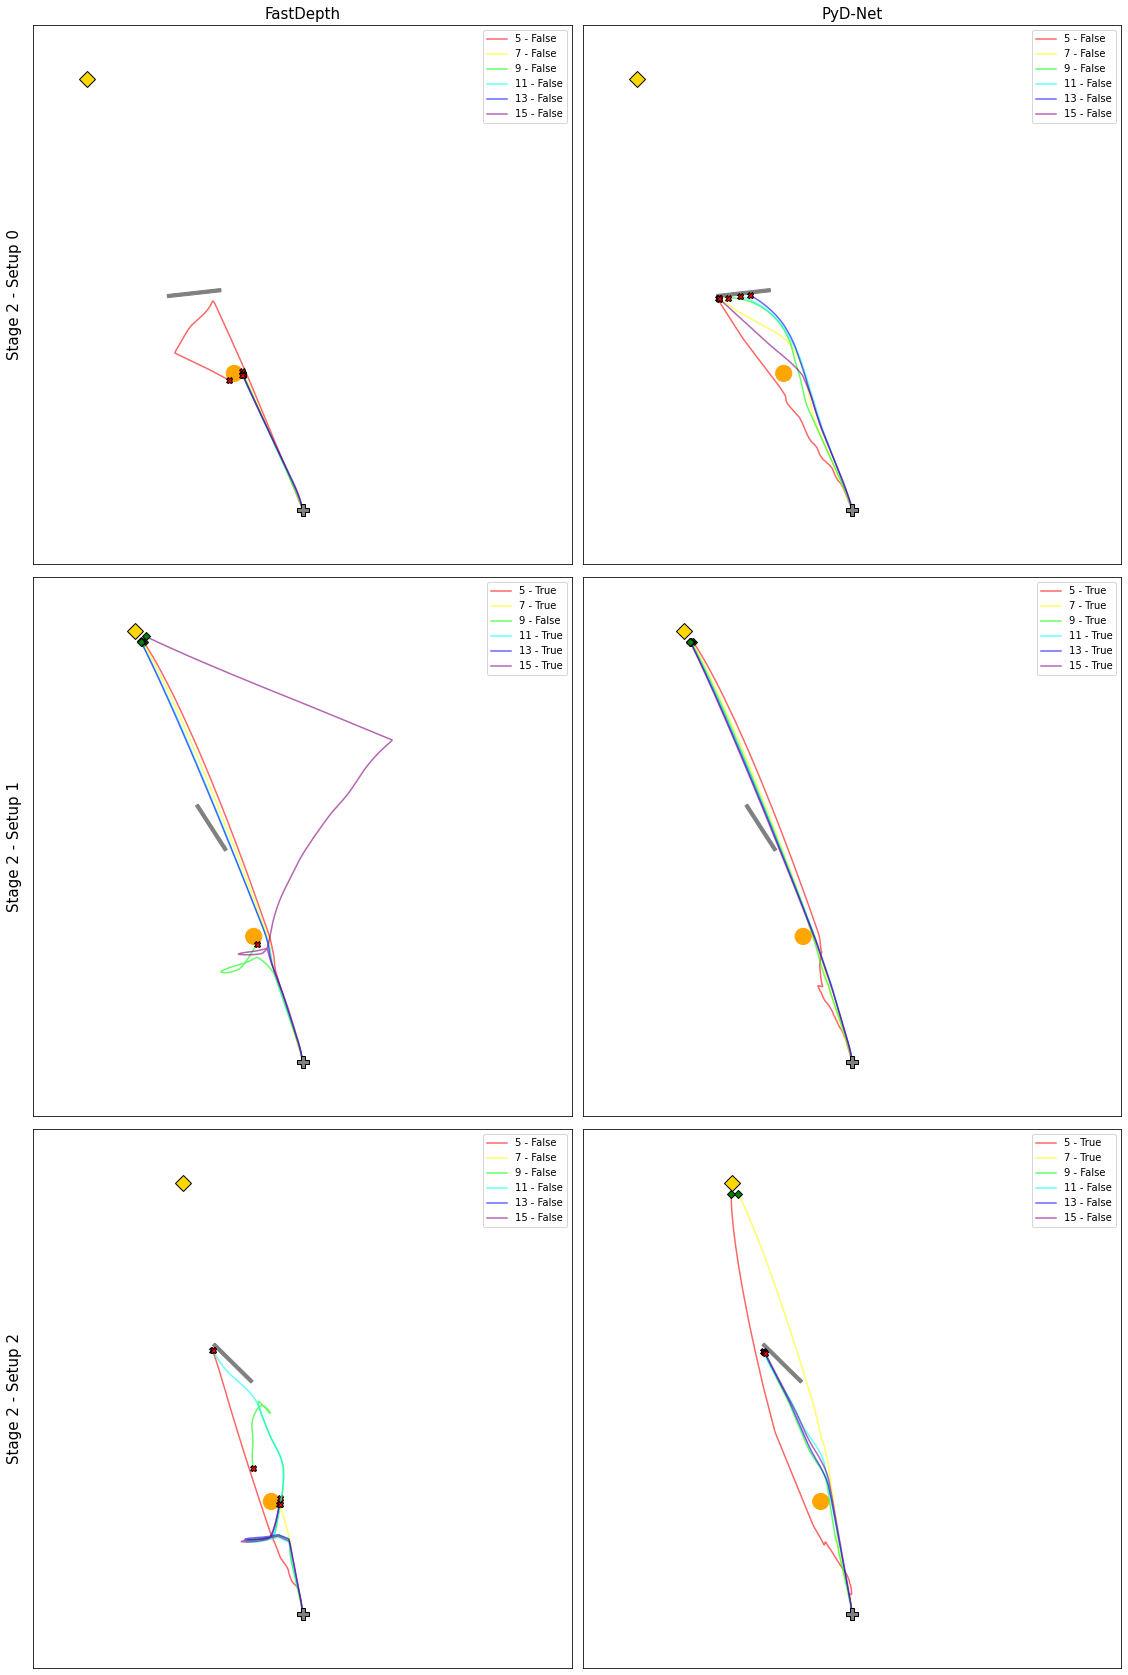

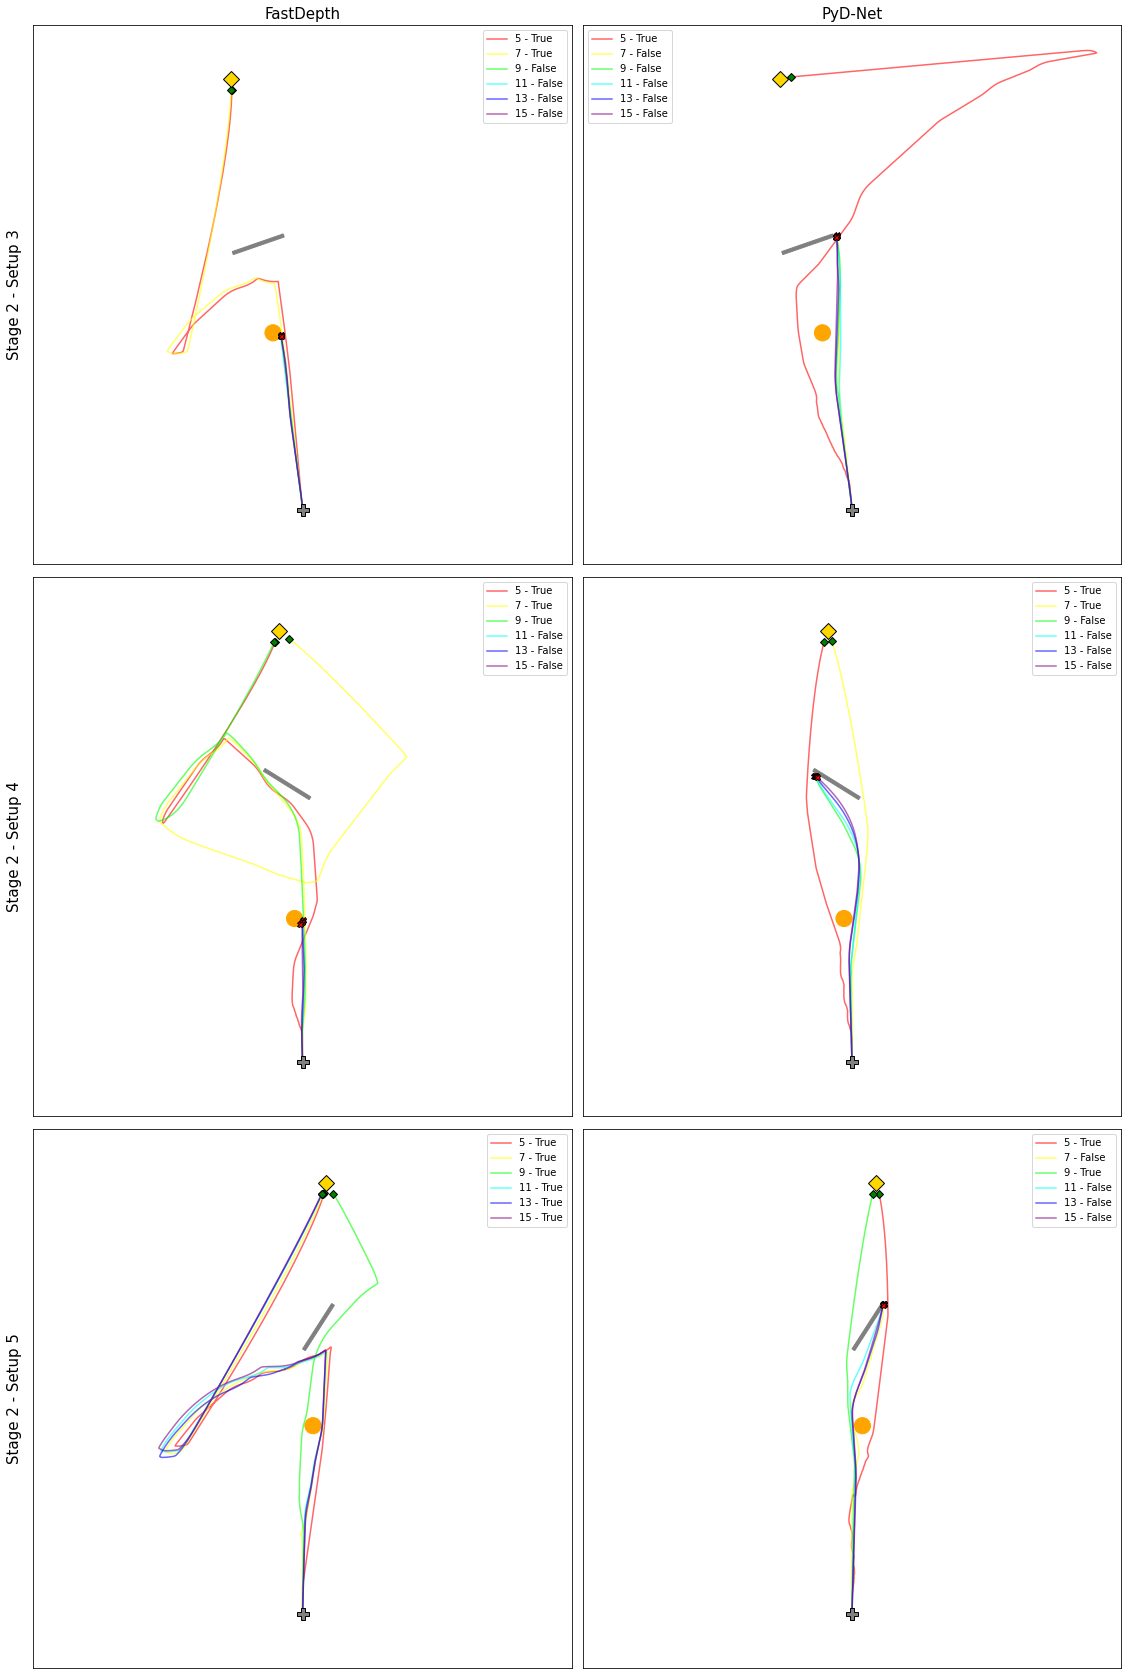

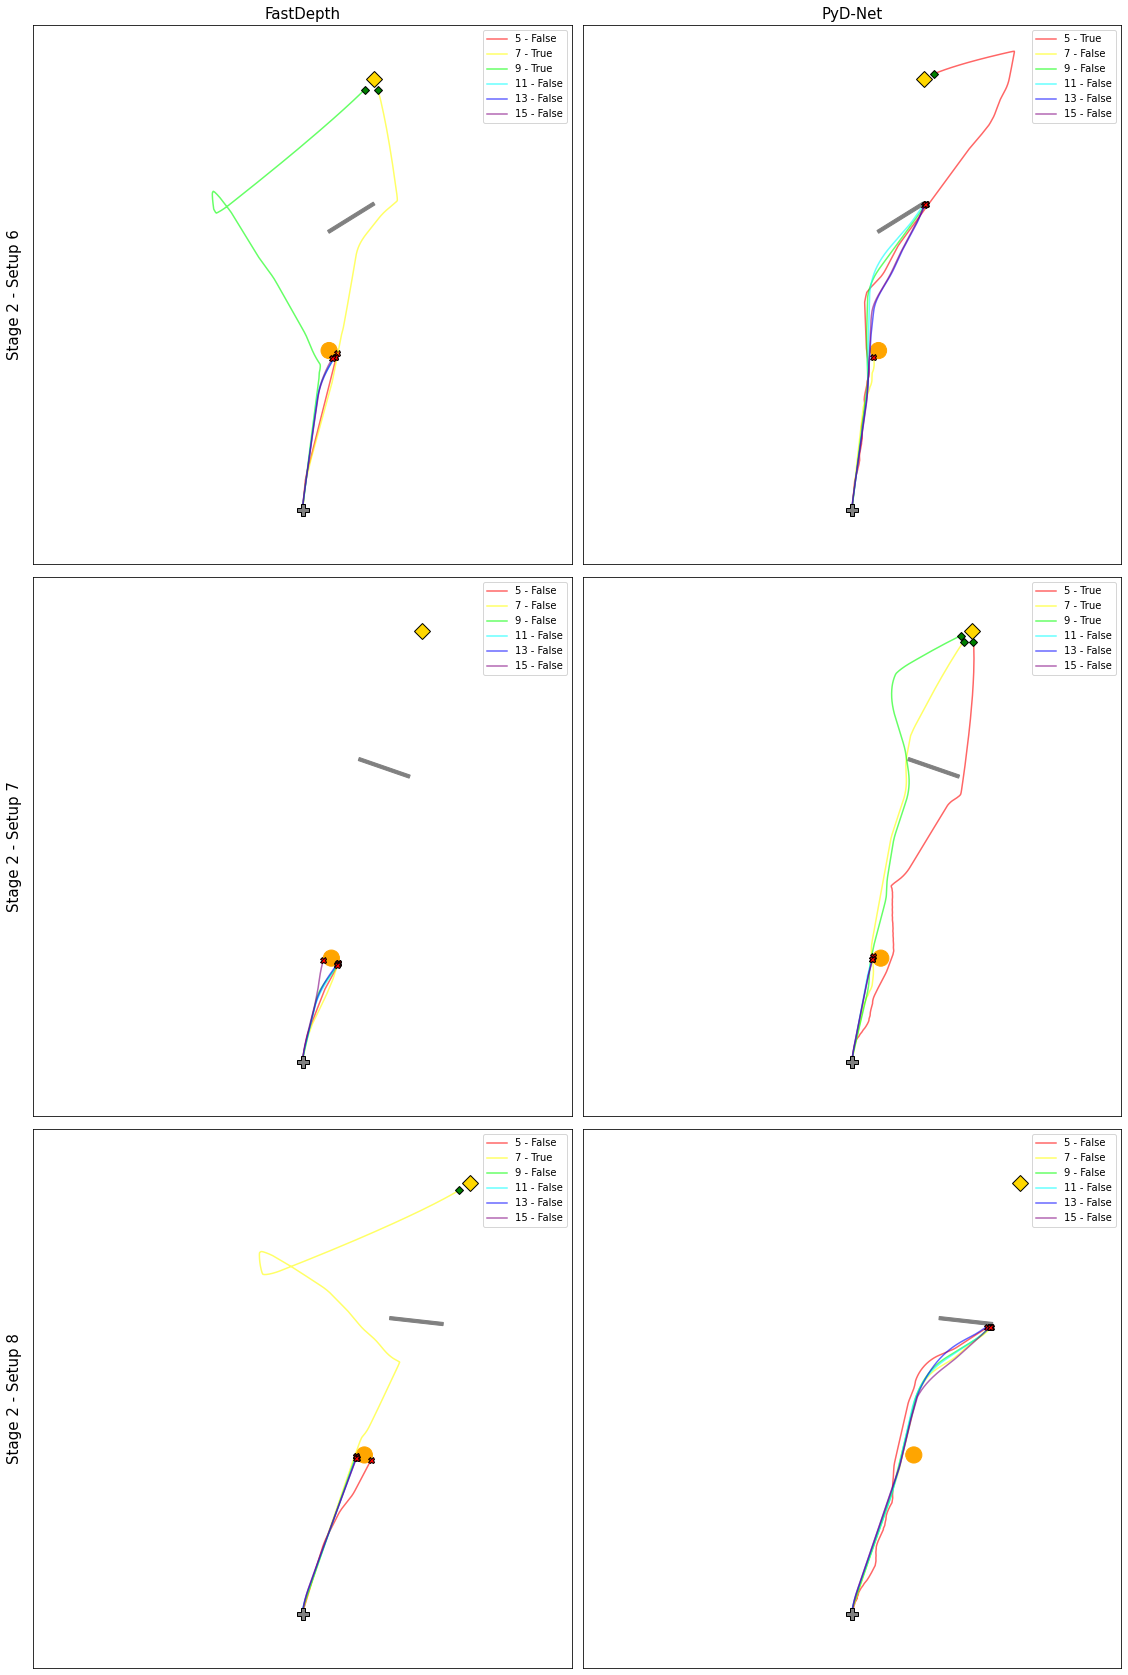

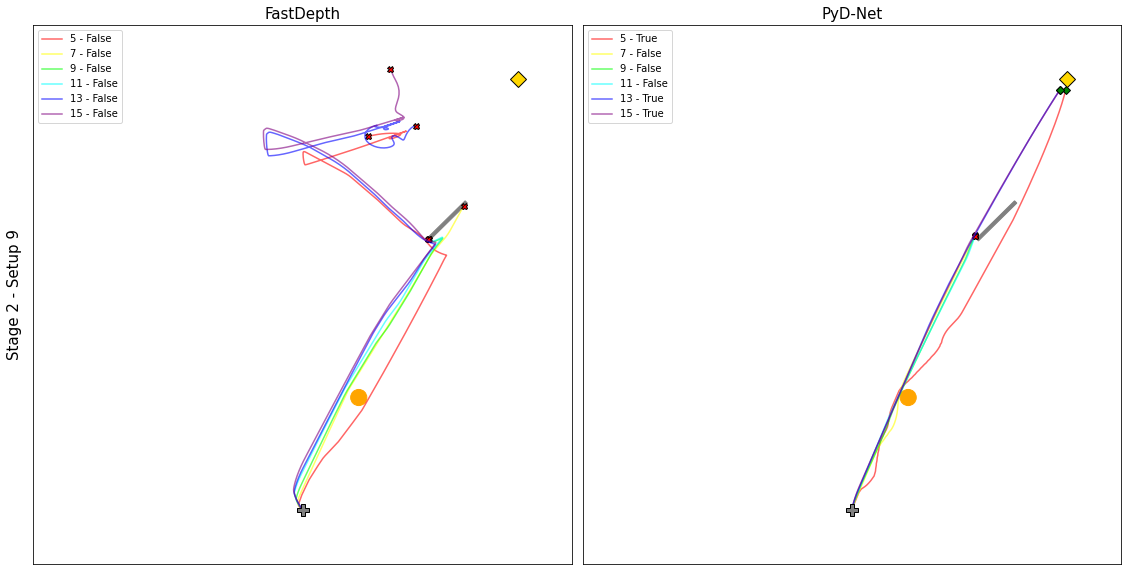

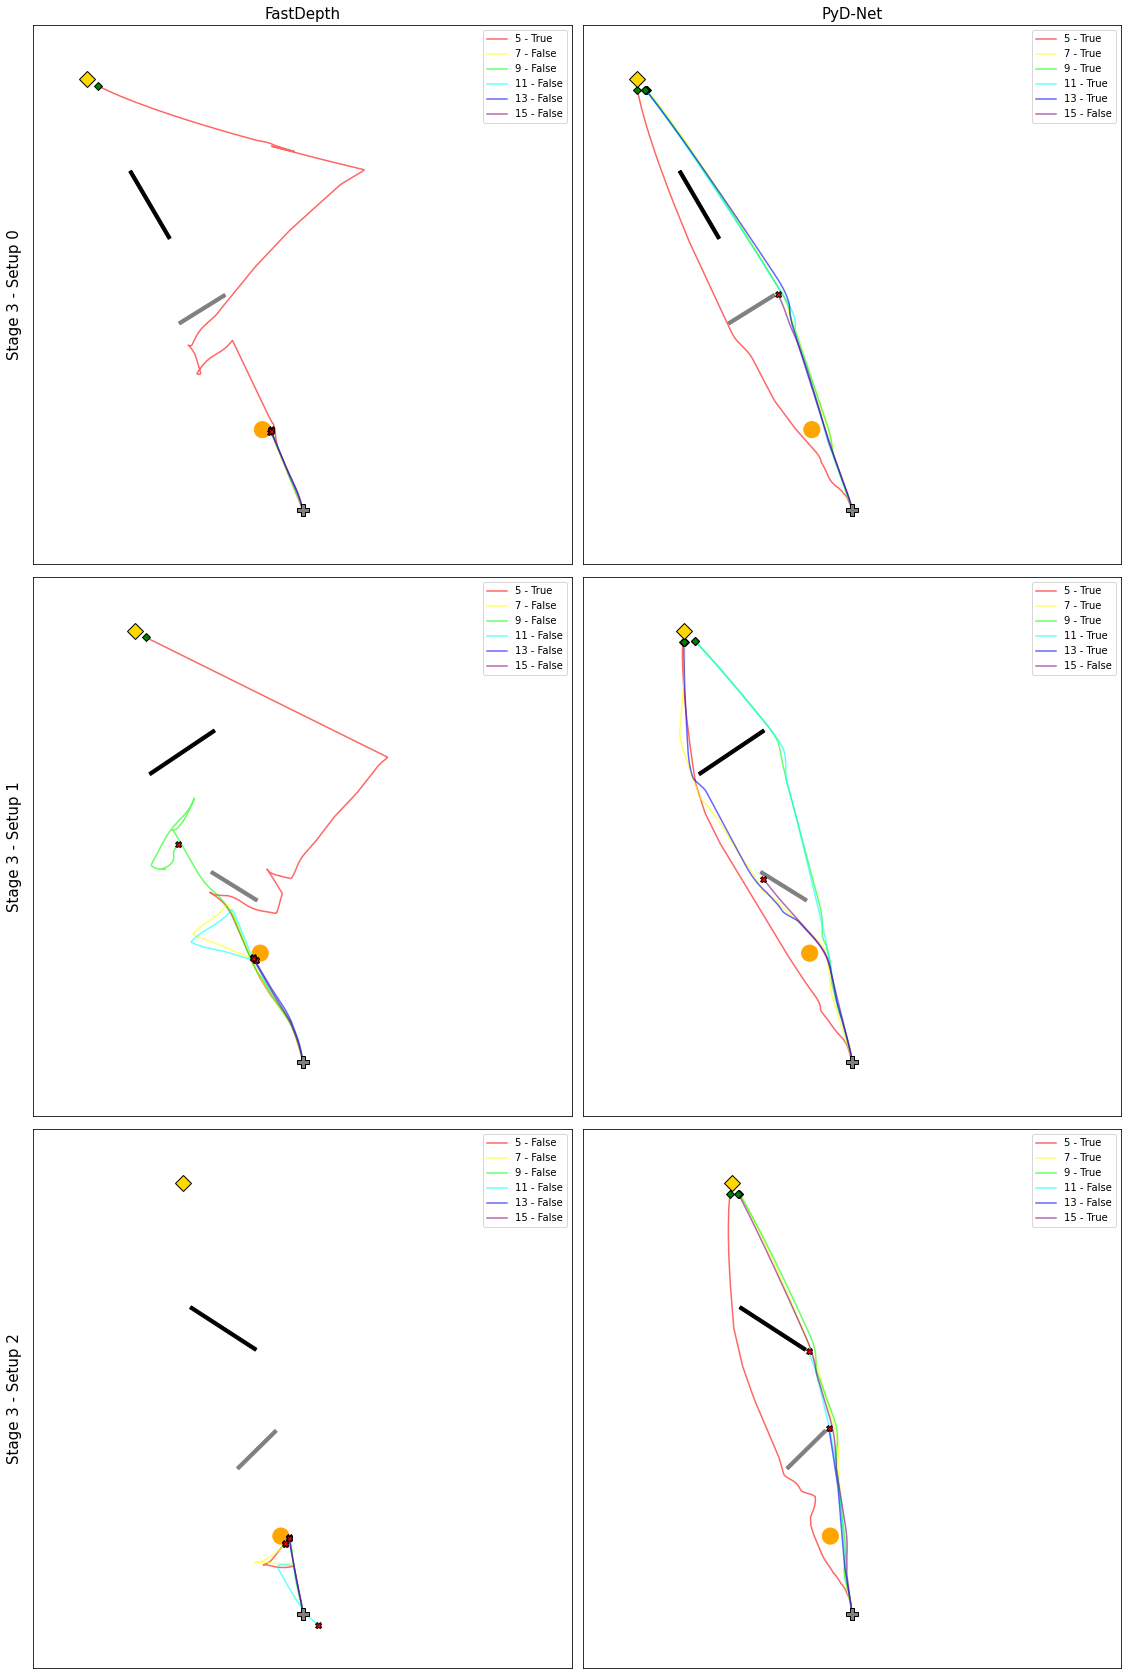

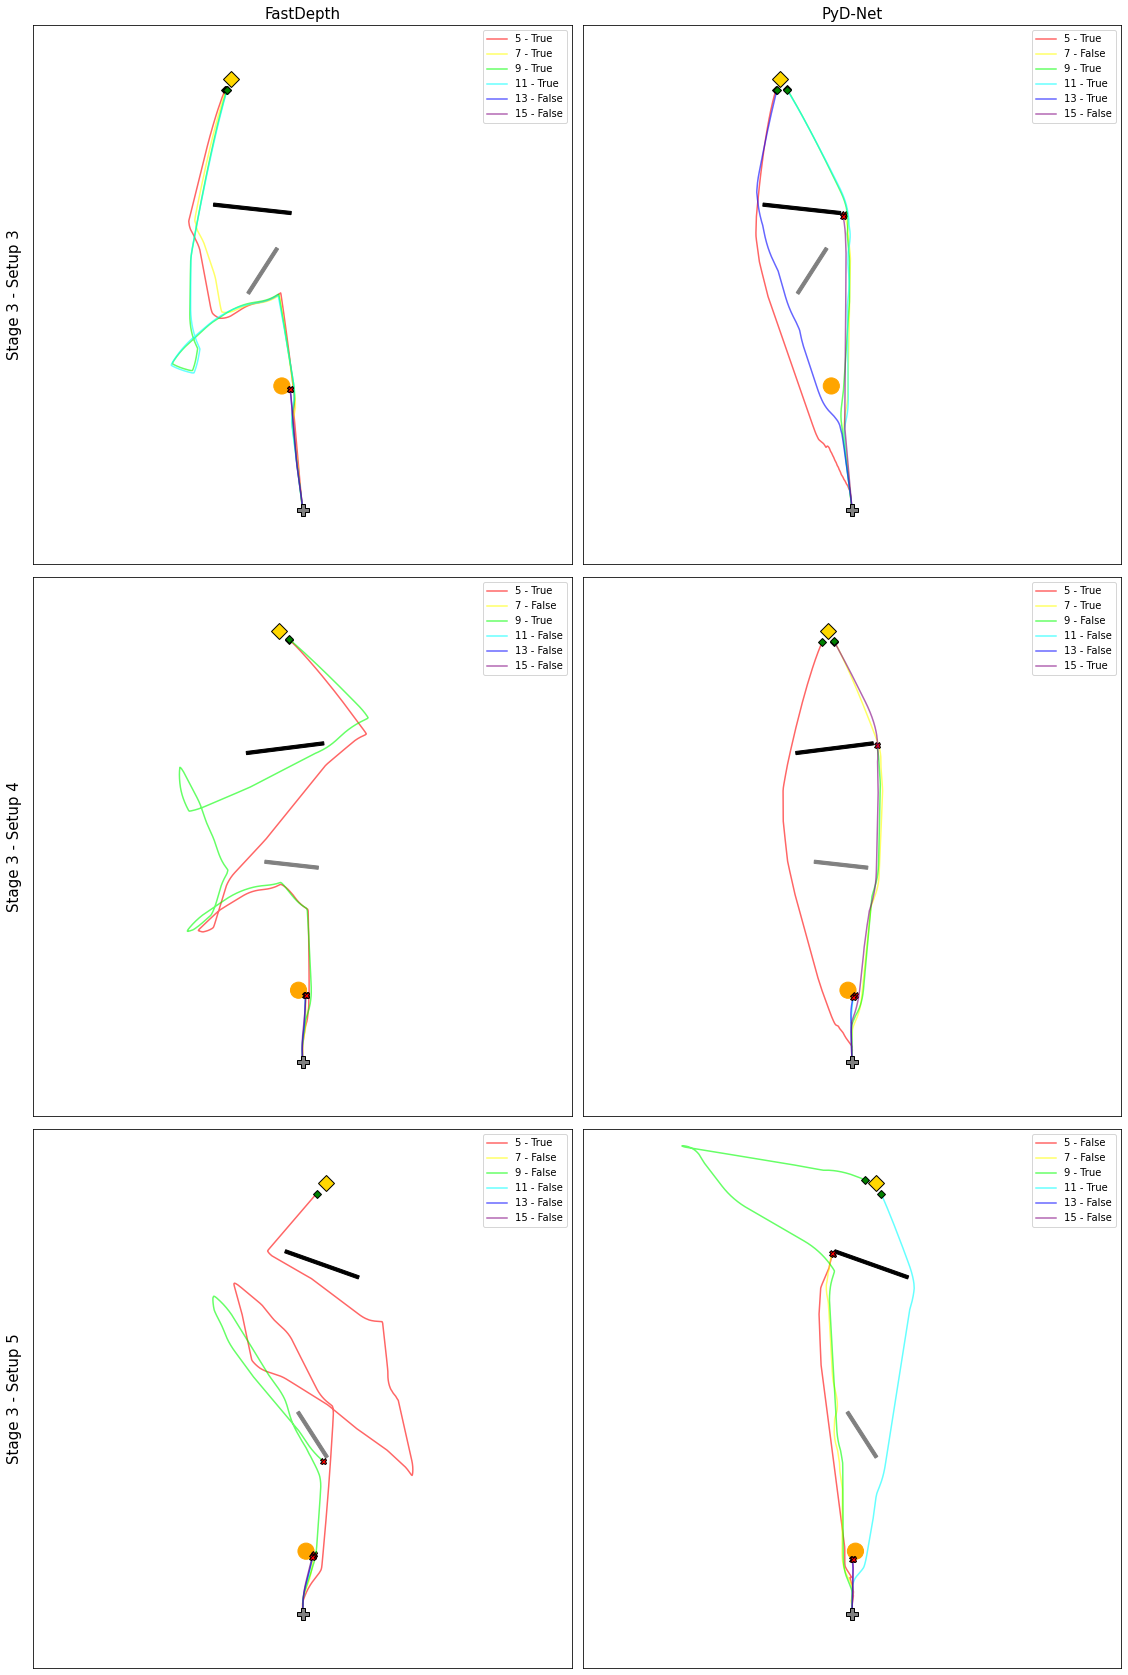

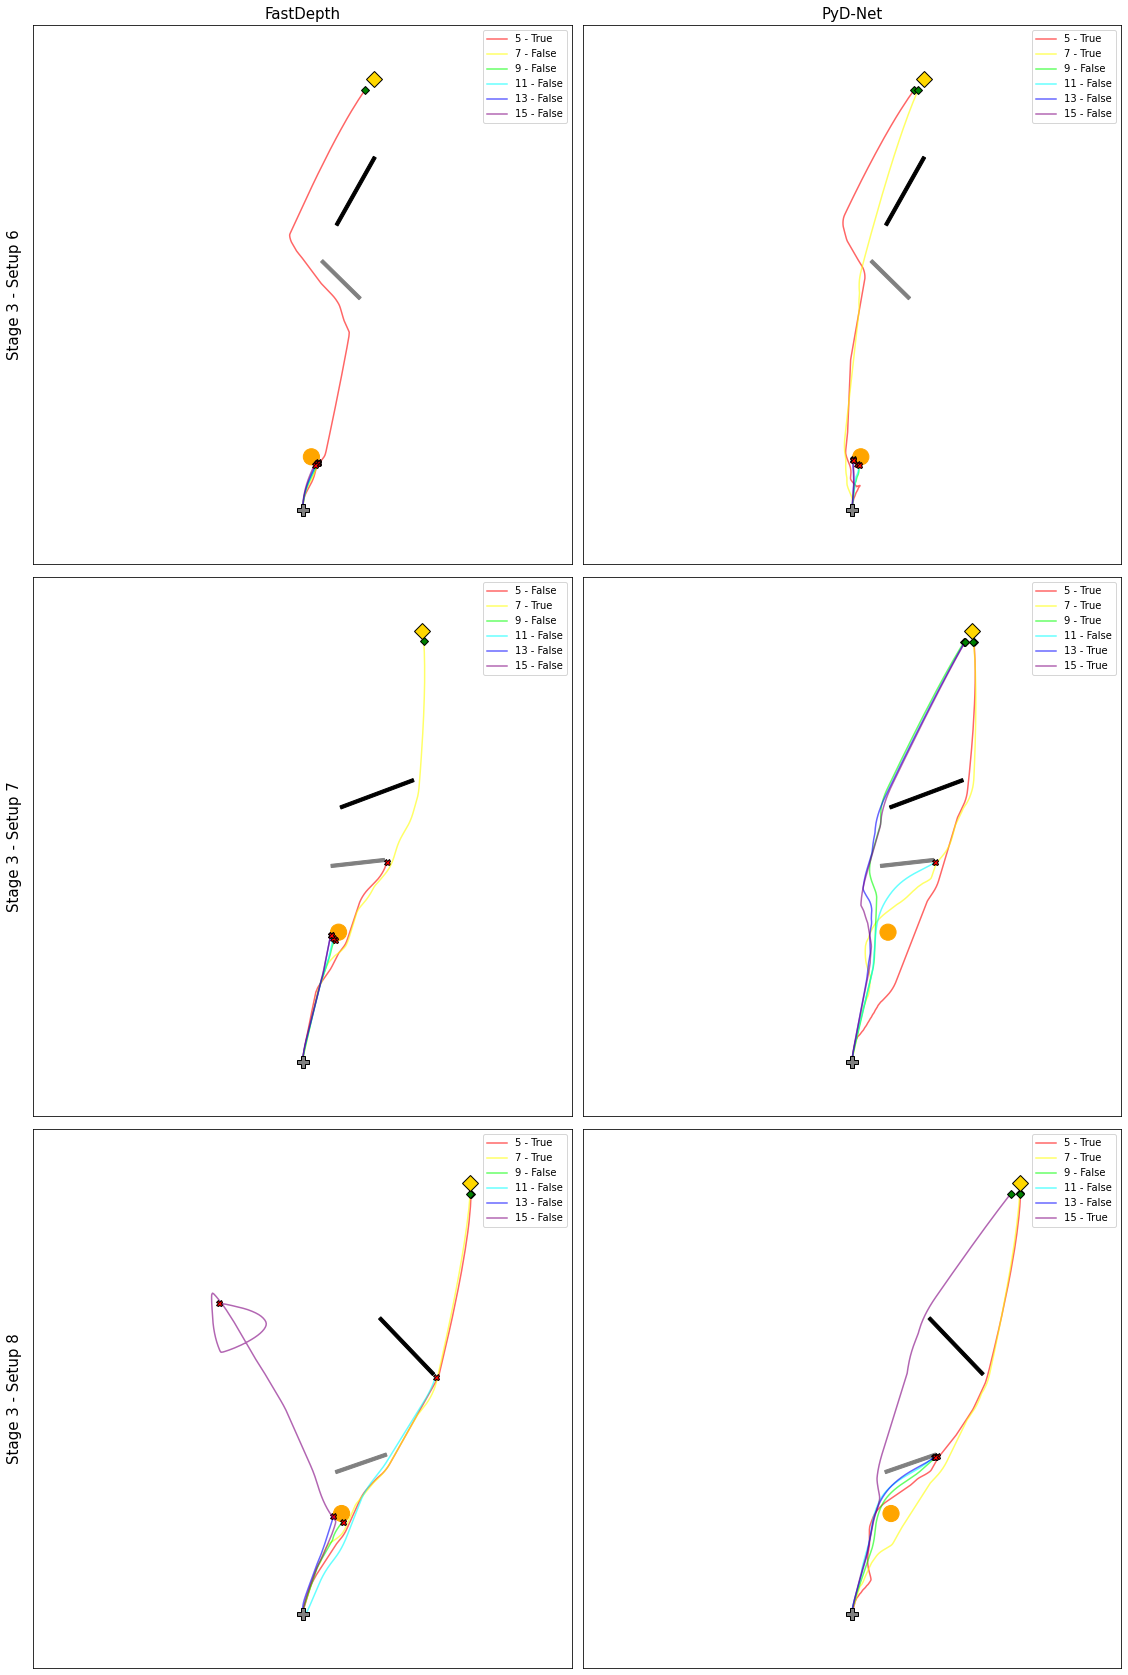

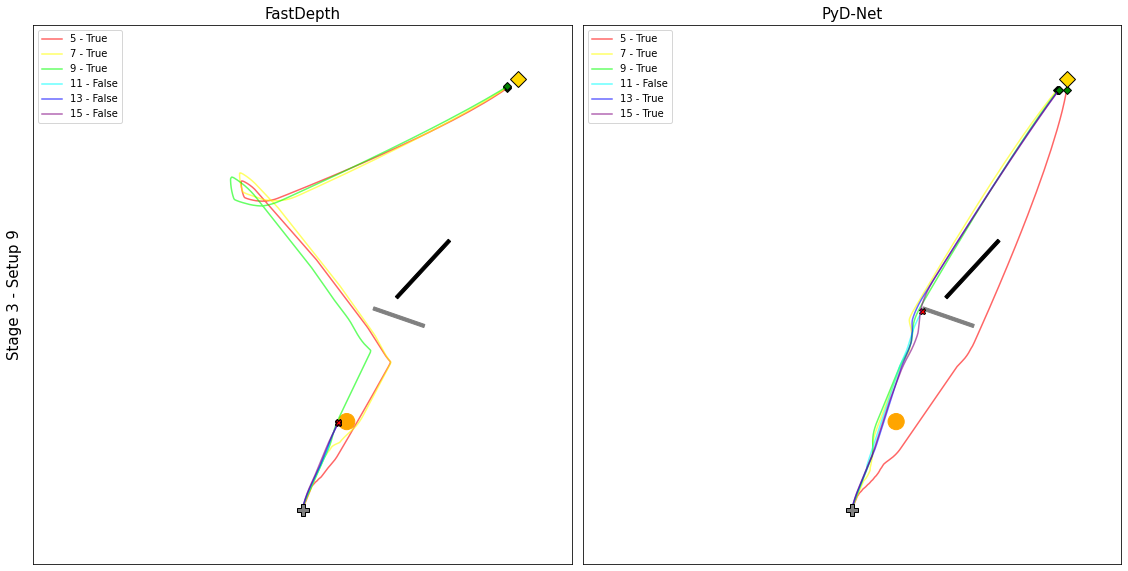

In [12]:
for level in range(3):
    apdxPlot = AppendixPlot(level+1, dronePos, stageSize)
    for startpos in [0, 3, 6, 9]:
        apdxPlot.plot(startpos)